# Process the Unsplash dataset with CLIP

This notebook processes all the downloaded photos using OpenAI's [CLIP neural network](https://github.com/openai/CLIP). For each image we get a feature vector containing 512 float numbers, which we will store in a file. These feature vectors will be used later to compare them to the text feature vectors.

This step will be significantly faster if you have a GPU, but it will also work on the CPU.

## Load the photos

Load all photos from the folder they were stored.

In [1]:
from pathlib import Path

# Set the path to the photos
# dataset_version = "lite"  # Use "lite" or "full"
photos_path = Path("featurescoop_salvatore") / "imgs"

# List all JPGs in the folder
photos_files = list(photos_path.glob("*.jpg"))
photos_files.sort()

# Print some statistics
print(f"Photos found: {len(photos_files)}")
print(*photos_files[:10], sep='\n')

Photos found: 16113
featurescoop_salvatore/imgs/mov1-Scene-001-01.jpg
featurescoop_salvatore/imgs/mov1-Scene-002-01.jpg
featurescoop_salvatore/imgs/mov1-Scene-003-01.jpg
featurescoop_salvatore/imgs/mov1-Scene-004-01.jpg
featurescoop_salvatore/imgs/mov1-Scene-005-01.jpg
featurescoop_salvatore/imgs/mov1-Scene-006-01.jpg
featurescoop_salvatore/imgs/mov1-Scene-007-01.jpg
featurescoop_salvatore/imgs/mov1-Scene-008-01.jpg
featurescoop_salvatore/imgs/mov1-Scene-009-01.jpg
featurescoop_salvatore/imgs/mov1-Scene-010-01.jpg


## Load the CLIP net

Load the CLIP net and define the function that computes the feature vectors

Label probs: 0.5117 4.41e-05 0.4883


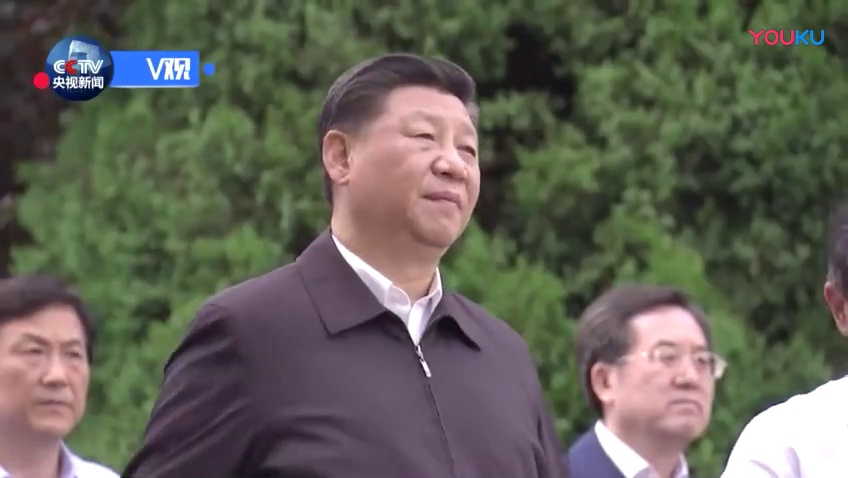

In [5]:
import torch
import clip
from PIL import Image
from IPython import display

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

image_fp = "featurescoop_salvatore/imgs/mov1-Scene-016-01.jpg"
image = preprocess(Image.open(image_fp)).unsqueeze(0).to(device)
text = clip.tokenize(["a photo of a dictator", "a photo of Jacques Chirac", "a photo of Xi JingPing"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", *probs[0])
display.Image(image_fp)

In [6]:
import clip
import torch
from PIL import Image

# Load the open CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Function that computes the feature vectors for a batch of images
def compute_clip_features(photos_batch):
    # Load all the photos from the files
    photos = [Image.open(photo_file) for photo_file in photos_batch]
    
    # Preprocess all photos
    photos_preprocessed = torch.stack([preprocess(photo) for photo in photos]).to(device)
    
    with torch.no_grad():
        # Encode the photos batch to compute the feature vectors and normalize them
        photos_features = model.encode_image(photos_preprocessed)
        photos_features /= photos_features.norm(dim=-1, keepdim=True)

    # Transfer the feature vectors back to the CPU and convert to numpy
    return photos_features.cpu().numpy()

## Process all photos

Now we need to compute the features for all photos. We will do that in batches, because it is much more efficient. You should tune the batch size so that it fits on your GPU. The processing on the GPU is fairly fast, so the bottleneck will probably be loading the photos from the disk.

In this step the feature vectors and the photo IDs of each batch will be saved to a file separately. This makes the whole process more robust. We will merge the data later.

In [ ]:
import math
import numpy as np
import pandas as pd

# Define the batch size so that it fits on your GPU. You can also do the processing on the CPU, but it will be slower.
batch_size = 64

# Path where the feature vectors will be stored
features_path = Path("featurescoop_salvatore") / "features"

# Compute how many batches are needed
batches = math.ceil(len(photos_files) / batch_size)

# Process each batch
for i in range(batches):
    print(f"Processing batch {i+1}/{batches}")

    batch_ids_path = features_path / f"{i:010d}.csv"
    batch_features_path = features_path / f"{i:010d}.npy"
    
    # Only do the processing if the batch wasn't processed yet
    if not batch_features_path.exists():
        try:
            # Select the photos for the current batch
            batch_files = photos_files[i*batch_size : (i+1)*batch_size]

            # Compute the features and save to a numpy file
            batch_features = compute_clip_features(batch_files)
            np.save(batch_features_path, batch_features)

            # Save the photo IDs to a CSV file
            photo_ids = [photo_file.name.split(".")[0] for photo_file in batch_files]
            photo_ids_data = pd.DataFrame(photo_ids, columns=['photo_id'])
            photo_ids_data.to_csv(batch_ids_path, index=False)
        except:
            # Catch problems with the processing to make the process more robust
            print(f'Problem with batch {i}')

Merge the features and the photo IDs. The resulting files are `features.npy` and `photo_ids.csv`. Feel free to delete the intermediate results.

In [8]:
import numpy as np
import pandas as pd

# Load all numpy files
features_list = [np.load(features_file) for features_file in sorted(features_path.glob("*.npy"))]

# Concatenate the features and store in a merged file
features = np.concatenate(features_list)
np.save(features_path / "features.npy", features)

# Load all the photo IDs
photo_ids = pd.concat([pd.read_csv(ids_file) for ids_file in sorted(features_path.glob("*.csv"))])
photo_ids.to_csv(features_path / "photo_ids.csv", index=False)